In [1]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))
## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Notebook Last Run Initiated: 2022-06-13 18:24:11.489131


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
# define documents
data = pd.read_csv('data\ZIP_TRACT_122021.csv',dtype={
                     'zip': str,
                     'tract': str,
                     'usps_zip_pref_city': str,
                     'usps_zip_pref_state': str,
                     'res_ratio': float,
                     'bus_ratio': float,
                     'oth_ratio': float,
                     'tot_ratio': float})

geodata = pd.read_csv('data\ZIP2LATLON_VER1.csv',dtype={
                      'postal_code': str,
                      'country_code': str,
                      'place': str,
                      'state': str,
                      'statecode': str,
                      'province_or_county': str,
                      'province_or_countycode': str,
                      'latitude': float,
                      'longitude': float})

geodata['postal_code'] = geodata['postal_code'].str.zfill(5)

In [4]:
data = pd.merge(data, geodata,  how='left', left_on=['zip'], right_on = ['postal_code'])
data = data.drop(['res_ratio', 'bus_ratio', 'oth_ratio', 'postal_code','country_code', 'state', 'statecode', 'province_or_countycode', 'place', 'tot_ratio'], axis=1)
data = data.fillna(0)

In [5]:
target = data[['latitude','longitude']]
data = data[['zip','tract','usps_zip_pref_city','usps_zip_pref_state','province_or_county']]

In [6]:
target = StandardScaler().fit_transform(target.values)

In [7]:
data['province_or_county'].replace([0], 'NONE ', inplace=True)

In [8]:
docs = data.iloc[:,0:5].apply(lambda x: ' '.join(x), axis=1)

In [9]:
# integer encode the documents
vocab_size = 131322
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

In [10]:
encoded_docs = t.texts_to_sequences(docs)

In [11]:
# pad documents to a max length of 4 words
max_length = 5
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [12]:
def BuildModel(learning_rate):
        
    input_text  = tf.keras.layers.Input(shape=(max_length,),name='text')

    x = tf.keras.layers.Embedding(vocab_size, 20, input_length=max_length,name='embeddings')(input_text)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(40, activation='relu',name='act01')(x)
    output = tf.keras.layers.Dense(1, activation='linear',name='linear_output')(x)
    
    model = Model(input_text,output)
    
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate))
    return model

In [13]:
learning_rate = 1e-3
n_epochs = 250

model = BuildModel(learning_rate)
        
ckp_path = f'models/Model_02.hdf5'

cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.4, patience = 5, verbose = 0, min_delta = 0.001, mode = 'min')
        
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(ckp_path, monitor='loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True)
        
    #tb_cb = tf.keras.callbacks.TensorBoard(log_dir="logs")

# train the model
model.fit(padded_docs,target,epochs=n_epochs, batch_size=256,
          callbacks=[mc,cb_lr_schedule,es], shuffle=False,
          workers=-1, use_multiprocessing=True, verbose=2)
        


Epoch 1/250
673/673 - 5s - loss: 0.5976 - lr: 0.0010 - 5s/epoch - 7ms/step
Epoch 2/250
673/673 - 4s - loss: 0.5075 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/250
673/673 - 4s - loss: 0.5064 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/250
673/673 - 4s - loss: 0.5062 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/250
673/673 - 4s - loss: 0.5057 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 6/250
673/673 - 4s - loss: 0.5068 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/250
673/673 - 4s - loss: 0.5055 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/250
673/673 - 4s - loss: 0.5057 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 9/250
673/673 - 4s - loss: 0.5040 - lr: 4.0000e-04 - 4s/epoch - 6ms/step
Epoch 10/250
673/673 - 4s - loss: 0.5035 - lr: 4.0000e-04 - 4s/epoch - 6ms/step
Epoch 11/250
673/673 - 4s - loss: 0.5034 - lr: 4.0000e-04 - 4s/epoch - 6ms/step
Epoch 12/250
673/673 - 4s - loss: 0.5033 - lr: 4.0000e-04 - 4s/epoch - 6ms/step
Epoch 13/250
673/673 - 4s - loss: 0.5036 - lr: 4.0000e-04 - 4s/epoch - 6ms/step
E

In [14]:
# evaluate the model
loss = model.evaluate(padded_docs, target, verbose=2)
print(loss)

5381/5381 - 7s - loss: 0.5030 - 7s/epoch - 1ms/step
0.5030257105827332


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 5)]               0         
                                                                 
 embeddings (Embedding)      (None, 5, 20)             2626440   
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 act01 (Dense)               (None, 40)                4040      
                                                                 
 linear_output (Dense)       (None, 1)                 41        
                                                                 
Total params: 2,630,521
Trainable params: 2,630,521
Non-trainable params: 0
_________________________________________________________________


In [16]:
embedding_layer = model.get_layer('embeddings')

In [17]:
embeddings = embedding_layer.get_weights()[0]

In [18]:
np.savetxt("embeddings_model3.csv", embeddings, delimiter=",")

In [19]:
embeddings[t.word_index['60126'],:]

array([-0.05465582,  0.08433419,  0.04478534,  0.04663463, -0.0020323 ,
        0.02895845,  0.02807515,  0.01854068,  0.00155508,  0.05953885,
       -0.04955504, -0.03011151, -0.01838452,  0.05736528,  0.02668369,
        0.04402238, -0.00925462, -0.01032946, -0.10862561,  0.02107894],
      dtype=float32)

In [20]:
cosine_similarity(np.reshape(embeddings[t.word_index['60126'],:],(1,20)),np.reshape(embeddings[t.word_index['60181'],:],(1,20)))[0][0]

0.3381834

In [21]:
1. - cdist(np.reshape(embeddings[t.word_index['60126'],:],(1,20)), np.reshape(embeddings[t.word_index['60163'],:],(1,20)), 'cosine')[0][0]

0.20990301794955224

In [22]:
states = pd.DataFrame(pd.unique(data.usps_zip_pref_state),columns=['states'])

In [23]:
states_list = []

for index, row in states.iterrows():
    state = row[0].lower()
    states_list.append(pd.concat([pd.Series(state), pd.DataFrame(np.reshape(embeddings[t.word_index[state],:],(1,20)))   ],axis=1))   

In [24]:
states = pd.concat(states_list)
states = states.reset_index(drop=True)

In [25]:
states.columns = range(states.columns.size)

In [26]:
x = StandardScaler().fit_transform(states.iloc[:,1:-1].values)

In [27]:
pca = PCA(n_components=2)

In [28]:
principalComponents = pca.fit_transform(x)

In [29]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [30]:
finalDf = pd.concat([principalDf, states.iloc[:,0]], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'State']

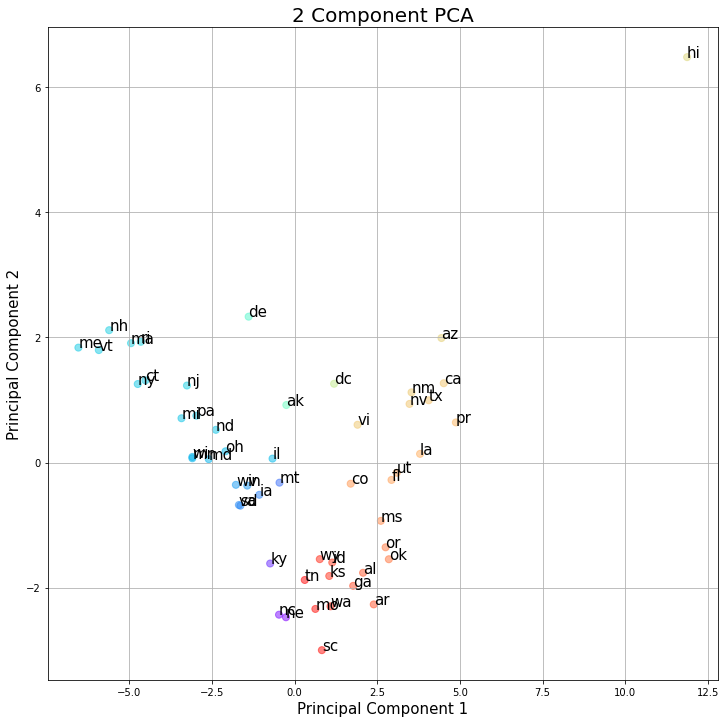

In [31]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

plt.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1], c=np.arctan2(finalDf.iloc[:,0], finalDf.iloc[:,1]),cmap='rainbow', s=50, alpha=0.5)

ax.grid()

for i, txt in enumerate(finalDf.iloc[:,2]):
    ax.annotate(txt, (finalDf.iloc[i,0], finalDf.iloc[i,1]),fontsize=15)
